In [1]:
# Change Current Directory
import os

current_dir = '../../'
os.chdir(current_dir)
current_working_directory = os.getcwd()

from src.codes.utils.plot_files.plot_utils import OneDPlot as plot
from src.codes.utils.rom_utils import *
from ecsw_fvm import ecsw_red
import time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Constants and Configuration
k = 1.
NUMCELLS = 1000*2
nodes = NUMCELLS + 2 

l = 1.
dx = l / NUMCELLS
S0 = 10

S = lambda x,mu: S0*np.cos(x/mu)
bc = {'0':1.,f'{NUMCELLS+1}':0}

mu = np.linspace(0.011,10,150)
sols = []

In [3]:
class Cell:

    def __init__(self,_midpoint, volume):
        self._midpoint = _midpoint
        self._volume = volume
        self.right_ngb = None
        self.surface_area = 1.
        self.bc = False


def initialize_cells(num_cells,mu):
    cells = []

    for i in range(num_cells):

        cell = Cell((i + 0.5)*dx, dx)
        cell.k_e = k
        cell.k_w = k
        cell.x_w = dx*i
        cell.x_e = dx*(i+1)
        cell.dxw = (cell.x_e - cell.x_w)
        cell.S_integrated = 0.5*dx*(S(cell.x_w,mu)+S(cell.x_e,mu)) # Trapezoid
        cells.append(cell)
        cell.bc = False

        if i == 0:
            cell.bc = True
            cell.bc_node = i
        elif i==num_cells-1:
            cell.bc = True
            cell.bc_node = i+2

    return cells


def bulid_A(cells,nodes,bc, mu):

    A = np.zeros((len(cells), nodes))
    b = np.zeros(len(cells))
    # Boundary condition
    indices_to_remove = []

    for i,cell in enumerate(cells):

        aw = -cell.k_w/cell.dxw
        ap = cell.k_w/cell.dxw + cell.k_e/cell.dxw
        ae = -cell.k_e/cell.dxw

        b[i] = cell.S_integrated

        if cell.bc==True:

            if i == 0:
                aw *= 2
                ap = np.abs(aw) + np.abs(ae)
                b[i] += -aw*bc[f'{cell.bc_node}']

                cell.cell_stiffness = np.array([aw,ap])
                cell.cell_rhs = b[i]

            else:
                ae *= 2
                ap = np.abs(aw) + np.abs(ae)
                b[i] += -ae*bc[f'{cell.bc_node}']

                cell.cell_stiffness = np.array([ap,ae])
                cell.cell_rhs = b[i]                

            indices_to_remove.append(cell.bc_node)
        
        else:
            cell.cell_stiffness = np.array([aw,ap,ae])
            cell.cell_rhs = b[i]

        
        A[i,i:i+3]= np.array([aw,ap,ae])

    # Sort indices in descending order to avoid index shifting issues
    indices_to_remove.sort(reverse=True)

    for index in indices_to_remove:
        A = np.delete(A, index, 1)

    L_plus = A.astype(bool)
    cell.L_plus=L_plus

    return A, b, L_plus


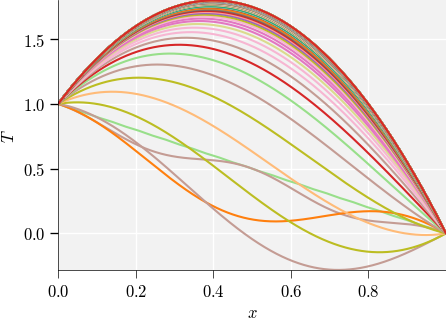

In [4]:
fig, ax = plt.subplots(figsize=(5,3.5))
All_cells = []
sim_time = []

for i in range(len(mu)):
    
    tic = time.time()

    cells = initialize_cells(NUMCELLS,mu[i])
    A,b,L_plus = bulid_A(cells,nodes,bc,mu[i])

    sol = np.linalg.solve(A,b)

    toc = time.time()

    sols.append(sol)
    sim_time.append(toc-tic)
    
    Plot = plot(dx*np.r_[0:len(sol)],sol, ax=ax)
    Plot.line_()
    
    All_cells.append(cells)

plt.show()


## ROM setup

In [5]:
train_mask, test_mask = train_test_split(len(sols))

NLS_train = np.asarray(sols)[train_mask]
NLS_test = np.asarray(sols)[test_mask]

mu_test = mu[test_mask]

sim_time = np.asarray(sim_time)
sim_time_test = sim_time[test_mask]

In [6]:
NLS_train_mean = np.mean(NLS_train,axis=0)
NLS_train_ms = NLS_train - NLS_train_mean
NLS_train_mean.shape

(2000,)

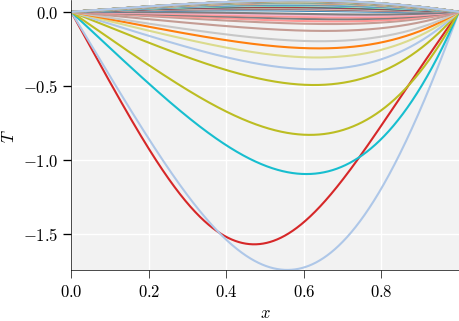

In [7]:
fig, ax = plt.subplots(figsize=(5,3.5))

for i in range(80):
    Plot = plot(dx*np.r_[0:len(sol)], NLS_train_ms[i], ax=ax)
    Plot.line_()
plt.show()

Number of modes selected: 3


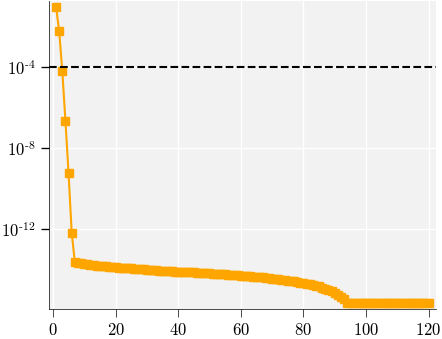

In [8]:
n_sel, U = svd_mode_selector(NLS_train_ms, tolerance=1e-4,modes=True)
V_sel = U[:, :n_sel]

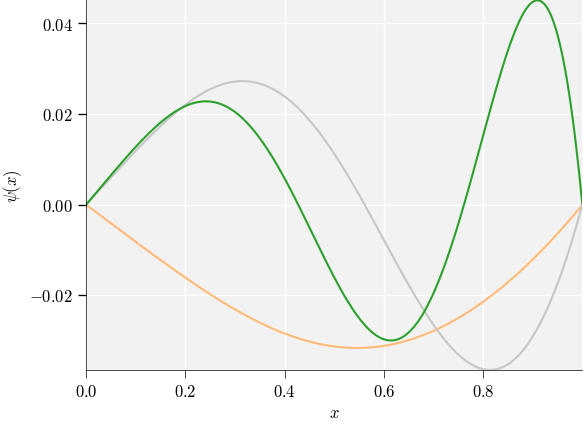

In [9]:
fig, ax = plt.subplots()

for i in range(n_sel):
    Plot = plot(dx*np.r_[0:len(sol)], V_sel[:,i], ax=ax)
    Plot.line_()
    
Plot.ax.set_xlabel('$x$')
Plot.ax.set_ylabel('$\psi(x)$')

plt.show()

In [10]:
def residual_f(i,j,sol,cell):

    res = np.dot(cell.cell_stiffness, sol) - cell.cell_rhs
    
    return res

residual_func = lambda i,j,sol,cell: residual_f(i,j,sol,cell)


### NNLS/ECSW

In [11]:
tic_h_setup_b = time.time()
N_snap_train,_ = np.shape(NLS_train)

tol = 1e-12

xi, res = ecsw_red(len(cells), V_sel, L_plus , All_cells, n_sel, N_snap_train, NLS_train_ms, NLS_train_mean, residual_func, tol=tol)

toc_h_setup_b = time.time()

norm of rhs: 1.0942838340948793


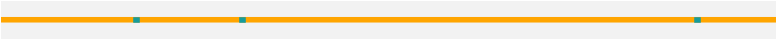

Fraction of total elements active in the ROM: 0.7%
residual = 7.399645051776226e-07


In [12]:
plot(np.arange(len(cells)), xi, ax="").element_()
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")
print(f"residual = {res}")

## ROM

In [13]:
def bulid_A_hyper(cells,nodes,bc, mu, xi, V, NLS_train_mean):

    A = np.zeros((len(cells), nodes))
    b = np.zeros(len(cells))
    # Boundary condition
    indices_to_remove = []

    for i,cell in enumerate(cells):

        if xi[i] == 0:
            continue

        aw = -cell.k_w/cell.dxw
        ap = cell.k_w/cell.dxw + cell.k_e/cell.dxw
        ae = -cell.k_e/cell.dxw

        b[i] = cell.S_integrated

        if cell.bc==True:

            if i == 0:
                aw *= 2
                ap = np.abs(aw) + np.abs(ae)
                b[i] += -aw*bc[f'{cell.bc_node}']

                cell.cell_stiffness = np.array([aw,ap])
                cell.cell_rhs = b[i]

            else:
                ae *= 2
                ap = np.abs(aw) + np.abs(ae)
                b[i] += -ae*bc[f'{cell.bc_node}']

                cell.cell_stiffness = np.array([ap,ae])
                cell.cell_rhs = b[i]                

            indices_to_remove.append(cell.bc_node)
        
        else:
            cell.cell_stiffness = np.array([aw,ap,ae])
            cell.cell_rhs = b[i]

        
        A[i,i:i+3]= np.array([aw,ap,ae])*xi[i]
        b[i] = b[i]*xi[i]

    # Sort indices in descending order to avoid index shifting issues
    indices_to_remove.sort(reverse=True)

    for index in indices_to_remove:
        A = np.delete(A, index, 1)

    A_r = V.T@A@V
    b_r = V.T@b - V.T@np.dot(A,NLS_train_mean)


    return A_r, b_r

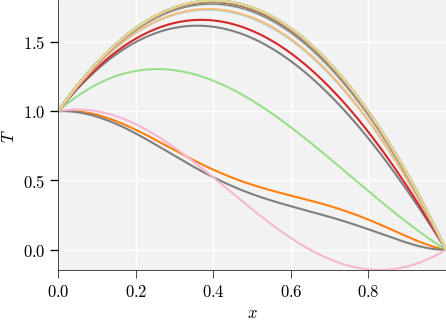

In [14]:
sol_red = []
fig, ax = plt.subplots(figsize=(5,3.5))
rom_err = []
sim_time_rom = []
speed_up = []

for i in range(len(mu_test)):

    tic_rom = time.time()
    cells = initialize_cells(NUMCELLS,mu_test[i])
    Ar,br, = bulid_A_hyper(cells,nodes,bc,mu_test[i],xi, V_sel, NLS_train_mean)

    sol_r = np.linalg.solve(Ar,br)
    sol_rom = np.dot(V_sel,sol_r) + NLS_train_mean

    toc_rom = time.time()
    sim_time_rom.append(toc_rom-tic_rom)

    speed_up.append(sim_time_test[i]/sim_time_rom[-1])

    sol_red.append(sol_rom)
    
    Plot = plot(dx*np.r_[0:len(sol)],sol_rom, ax=ax)
    Plot.line_()

    rom_err.append(np.linalg.norm(sol_rom-NLS_test[i])/np.linalg.norm(NLS_test[i]))

plt.show()

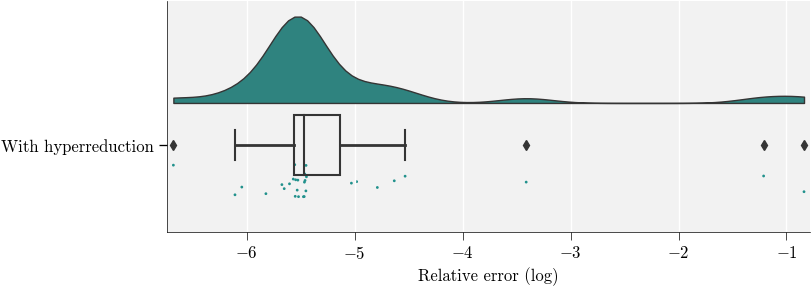

In [15]:
import ptitprince as pt
import pandas as pd

df = pd.DataFrame({'':'With hyperreduction','Relative error (log)':np.log10(rom_err)})
fig, ax = plt.subplots(figsize=(8.3, 3))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df, palette = "viridis", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =2.0, move=0.2)
plt.show()


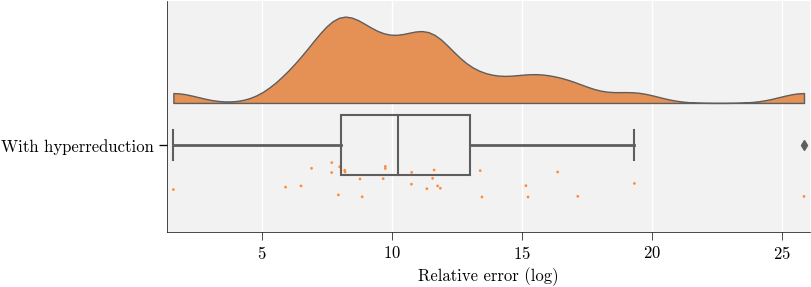

In [16]:
import ptitprince as pt
import pandas as pd

df2 = pd.DataFrame({'':'With hyperreduction','Relative error (log)':speed_up})
fig, ax = plt.subplots(figsize=(8.3, 3))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df2, palette = "Oranges", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =2.0, move=0.2)
plt.show()
